In [3]:
import cv2
import matplotlib.pyplot as plt
import numpy as np

In [4]:
######### WATERSHED ALGORITHM #########

In [12]:
def display(img,cmap=None):
    fig = plt.figure(figsize=(10,8))
    ax = fig.add_subplot(111)
    ax.imshow(img,cmap='gray')

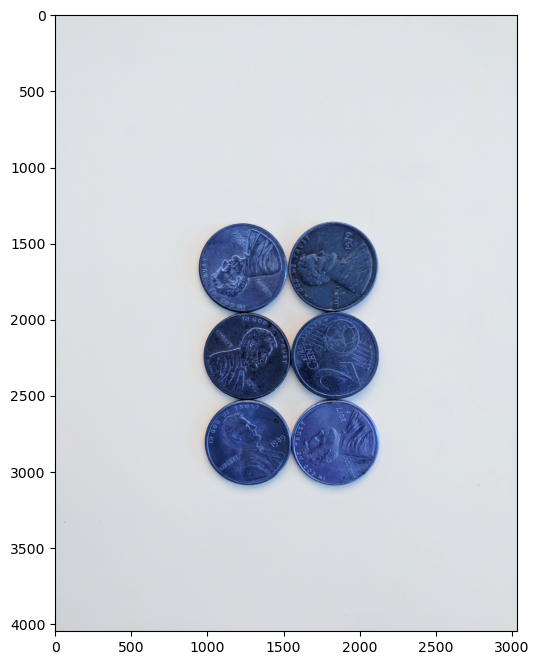

In [13]:
sep_coins =cv2.imread('DATA/pennies.jpg')
display(sep_coins)

In [14]:
# Median Blur
# Grayscale
# Binary Threshold
# Find Contours

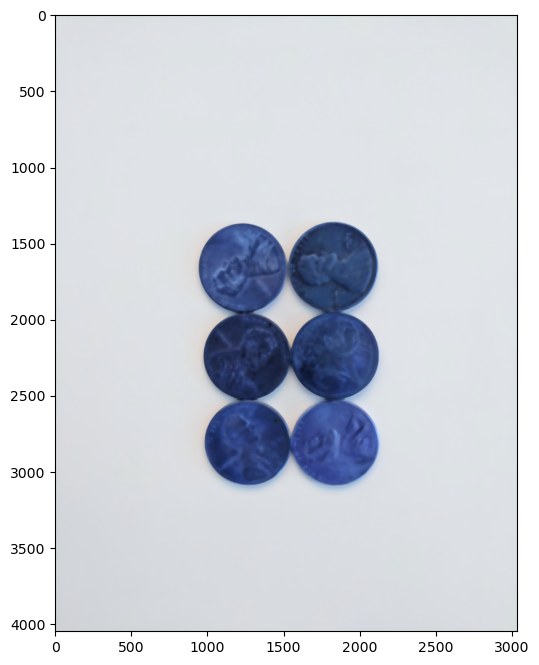

In [15]:
sep_blur = cv2.medianBlur(sep_coins,25)
display(sep_blur)

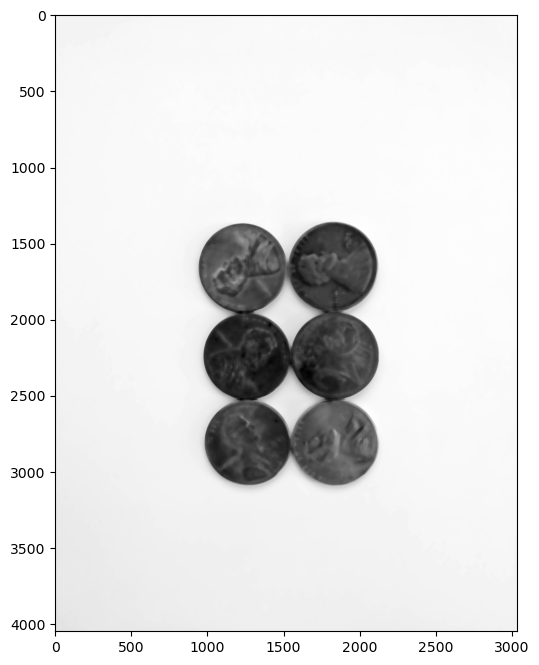

In [16]:
gray_sep_coins = cv2.cvtColor(sep_blur,cv2.COLOR_BGR2GRAY)
display(gray_sep_coins)

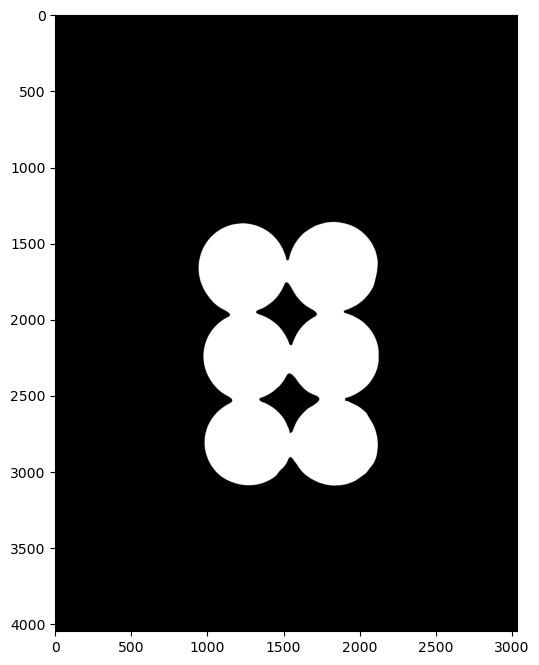

In [18]:
ret, sep_thresh = cv2.threshold(gray_sep_coins,160,255,cv2.THRESH_BINARY_INV)
display(sep_thresh)

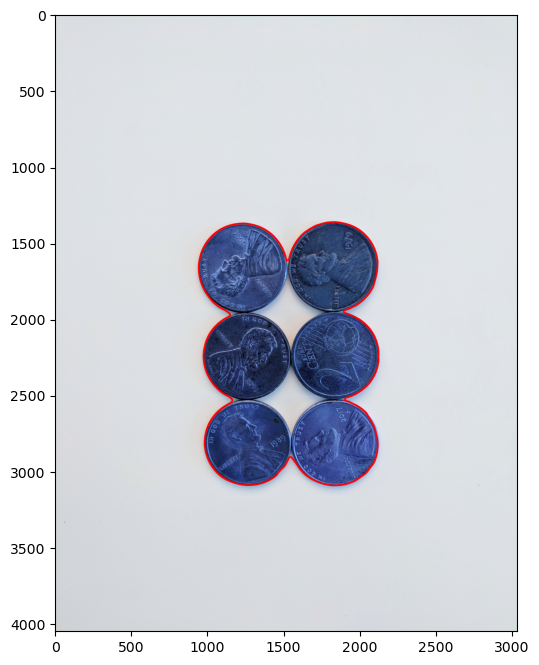

In [24]:
contours ,hierarchy = cv2.findContours(sep_thresh.copy(),cv2.RETR_CCOMP,cv2.CHAIN_APPROX_SIMPLE)

for i in range(len(contours)):
    if hierarchy[0][i][3] == -1:
        cv2.drawContours(sep_coins,contours,i,(255,0,0),10)

display(sep_coins)

In [25]:
# As you can see in the above operations the methods we applied could not actually find contours of 
# those all six coins but found the contours of the entire set as one, so to perform more better counter
# processing we need to apply the watershed algorithm

# Watershed Algorithm

#### Step 1: Read Image

In [26]:
img = cv2.imread('DATA/pennies.jpg')

#### Step 2: Apply Blur

In [27]:
img_blur = cv2.medianBlur(img,35)

#### Step 3: Convert to GrayScale

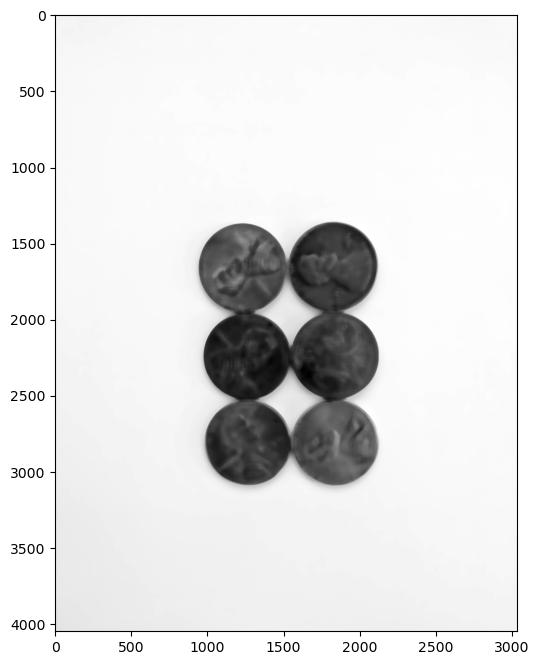

In [29]:
img_gray = cv2.cvtColor(img_blur,cv2.COLOR_BGR2GRAY)
display(img_gray)

### Step 4: Appplying threshold

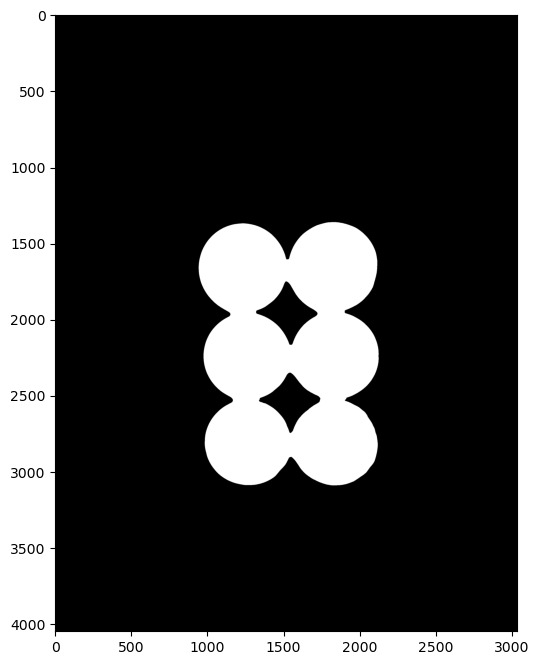

In [35]:
ret, img_thresh = cv2.threshold(img_gray,0,255,cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)

#  0: This is the threshold value, but in this case, since we are using cv2.THRESH_OTSU, this value 
# is ignored. OpenCV will automatically determine the optimal threshold value.

#  cv2.THRESH_OTSU: This flag is used to automatically calculate the optimal threshold value based on 
# the image histogram. The key idea of Otsu’s method is that it automatically calculates the optimal 
# threshold by minimizing the intra-class variance (the variance within each of the two groups of 
# pixels — foreground and background).

display(img_thresh)

### Optional Step 5: Noise Removal

In [40]:
kernel = np.ones((3,3),np.uint8)

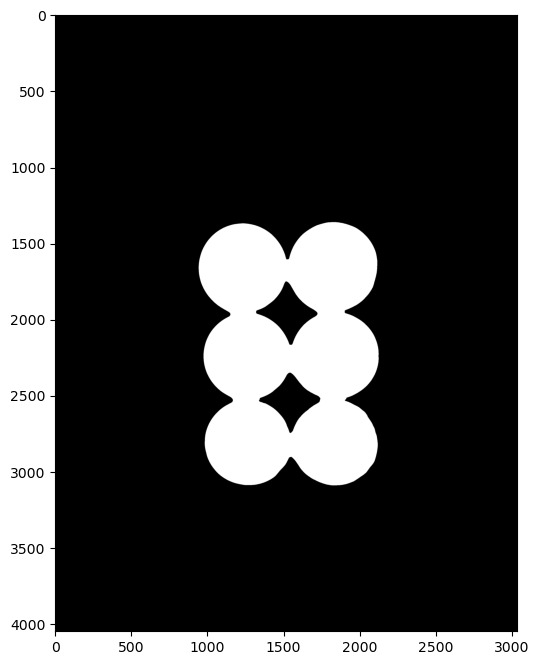

In [41]:
opening = cv2.morphologyEx(img_thresh,cv2.MORPH_OPEN,kernel,iterations=2)
display(opening) # cv2.MORPH_OPEN to remove background noise
                # cv2.MORPH_CLOSE to remove the foreground noise

### Step 6: Dilate the background for further process when we trace only the background, gerenating the sure background 

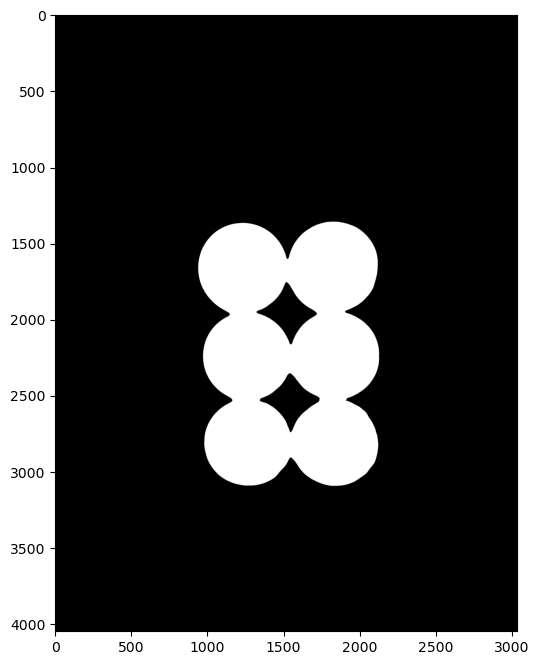

In [47]:
sure_background = cv2.dilate(opening,kernel=kernel,iterations=3)
display(sure_background,cmap='gray')

#### Step 7: Distance transform
1) https://reference.wolfram.com/language/ref/Files/DistanceTransform.en/O_1.png
2) https://en.wikipedia.org/wiki/File:Distance_Transformation.gif

In OpenCV, a DISTANCE TRANSFORM calculates the distance of each pixel in a binary image from the nearest zero pixel (background). It transforms the binary image such that every foreground pixel (non-zero pixel) is replaced by its distance to the closest background pixel.

LINK 1) What that basically means is that every pixel that is away from the foreground position Which is the position of the pixels which are equal to one are much more brightened compared to the pixels that are away from that foreground position so you will find in the reference link one that a horse in the foreground has brightened in the middle as that is the max foreground position and then fades away slowly till the image gets to its edges.

LINK 2) The transformation of pixels in the process is given in an example image of how the pixels process and change in the left hand side it is before processing and on the right hand side it is after processing as you can see in the middle of that image on the right hand side pixels are much more brightened like the pixel with the value of three is extremely brightened compared to the pixels on the left hand side.

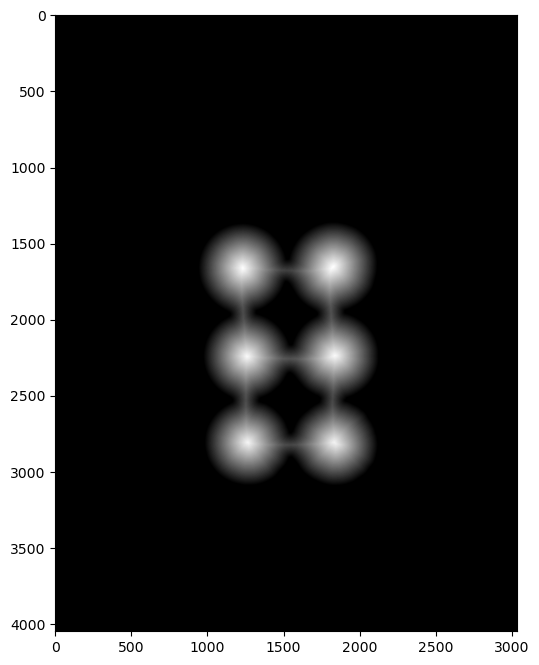

In [48]:
dist_transform = cv2.distanceTransform(opening,cv2.DIST_L2,5)
display(dist_transform)

# cv2.distanceTransform(): This function computes the distance transform of a binary image. 
# Each pixel's value is replaced by its distance to the nearest zero pixel (background).

# cv2.DIST_L2 - cv2.DIST_L2: This specifies the type of distance metric used. 
# This is the Euclidean distance (straight-line distance). In other words, the distance 
# from a pixel to the nearest background pixel is calculated using the Pythagorean theorem 
# (i.e., the shortest direct distance).

# 5: This is the size of the mask used to compute the distance transform.
# It defines the neighborhood size for computing the distances. A value of 5 means that 
# OpenCV considers a 5x5 region around each pixel when calculating the distance. Larger 
# values consider a bigger neighborhood, but the default is usually sufficient for most cases.

### Step 8 - gerenating the sure foreground 

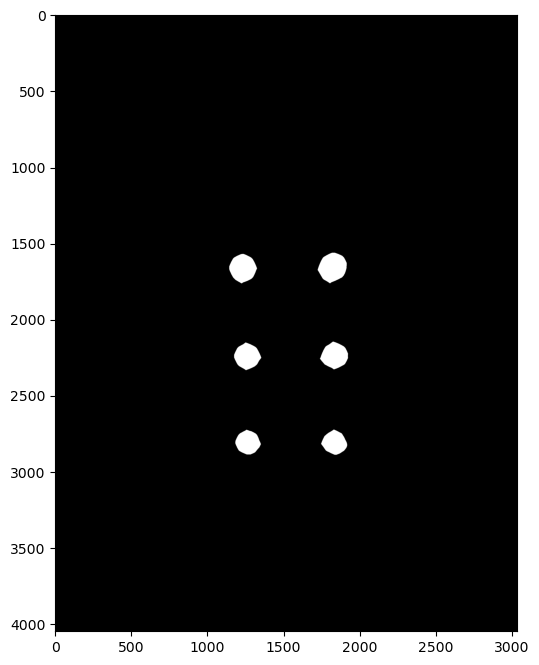

In [49]:
ret , sure_foreground = cv2.threshold(dist_transform,0.7*dist_transform.max(),255,0)
display(sure_foreground)

# The 0 at the end represents the type of thresholding being applied by the cv2.threshold() function. 
# Specifically, this 0 corresponds to cv2.THRESH_BINARY, which means that binary thresholding is being 
# used.

In [51]:
sure_foreground = np.uint8(sure_foreground)

Now we are sure of what lies in the background and what lies in the foreground but there's still an unknown region between the foreground and the background which we need to find now in the further steps

### Step 9 - generating the unknown region 

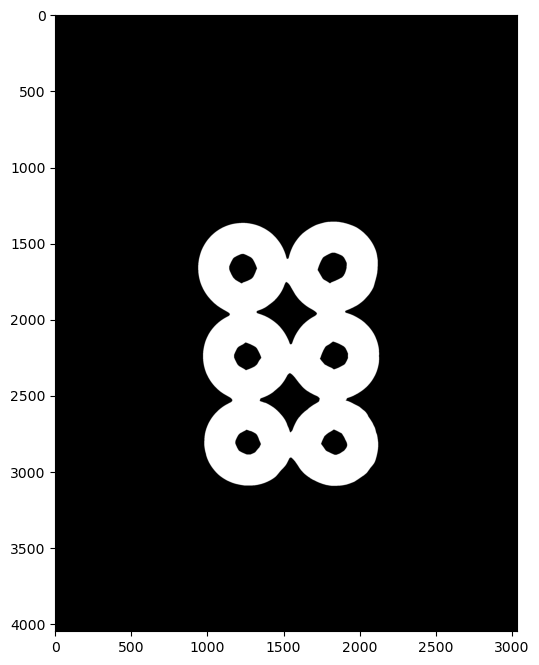

In [52]:
unknown_region = cv2.subtract(sure_background,sure_foreground)
display(unknown_region)

# So you see in the image below this is the region we're not yet sure about if they are 
# background or foreground

### Step 10 - Generating the label markers for the watershed algorithm 

markers = markers + 1 

markers[unknown_region==255] = 0
display(markers)

In [59]:
# To understand the cv2.connectedComponents() we first need to understand the concept of
# connected components 

# PLEASE HEAD TO OPENCV WORD FILE POINT 26) TO UNDERSTAND 

# sure_foreground: This is the binary image where the foreground (typically the object of interest) 
# has non-zero values (e.g., 255) and the background has zero values (e.g., 0). The goal is to label
# each connected region (object)

ret , markers = cv2.connectedComponents(sure_foreground)
markers

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32)

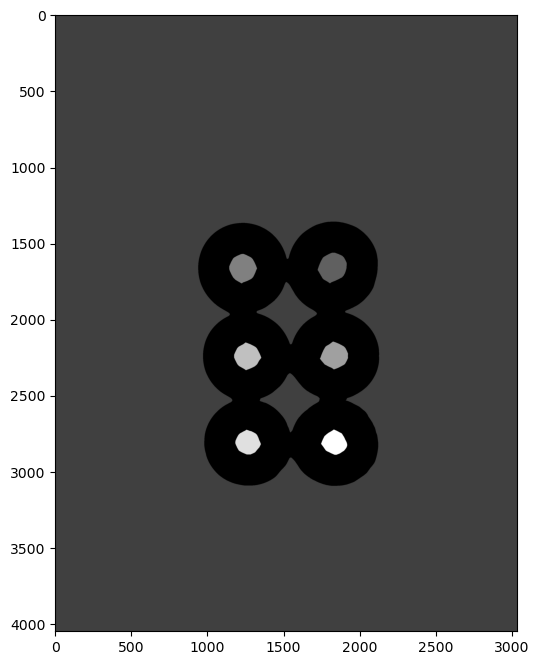

In [61]:
# the background of as image default labeled as 0. 

# we want to add one to all these labels so that the sure background is not zero but one.
# So we're gonna say markers is equal to markers plus one.

# basicaLLY markers = markers + 1: Shifts all labels by 1 to ensure the background is labeled as 1 
# instead of 0.

#Adding 1 to all values in the markers image is done to ensure that the background is not labeled as
# 0 anymore. Instead, the background becomes 1, and all other regions (previously labeled as 1, 2, 3, ...)
# become 2, 3, 4, .... This step is important in algorithms like Watershed because, in the Watershed 
# algorithm, regions labeled as 0 are treated as "unknown" or boundary regions, and not as background.

markers = markers + 1
markers[unknown_region==255] = 0
display(markers)

# markers where unknown, is equal to 255 because remember this is the unknown right here. These little 
# donuts, that's where we're not sure if that belongs to the background or to the foreground of the coin
# itself. So what I'll do is I'm going to label those as completely black.

### Step 11 - FINALLY Apply the watershed algorithm to our last output of markers  

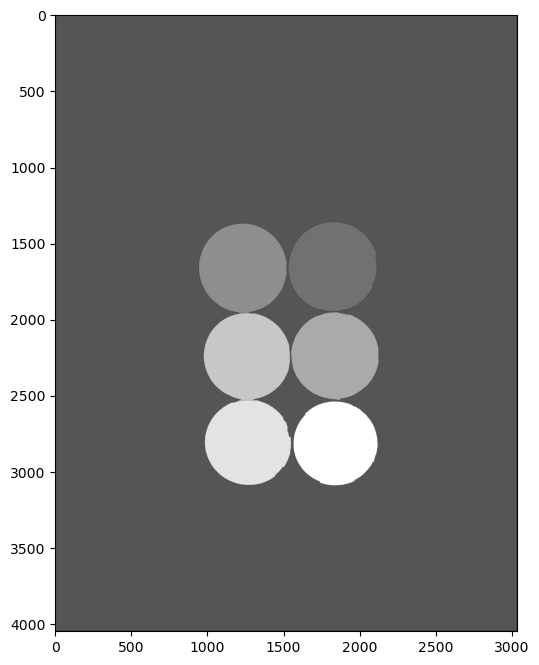

In [62]:
markers = cv2.watershed(img,markers=markers)
display(markers)

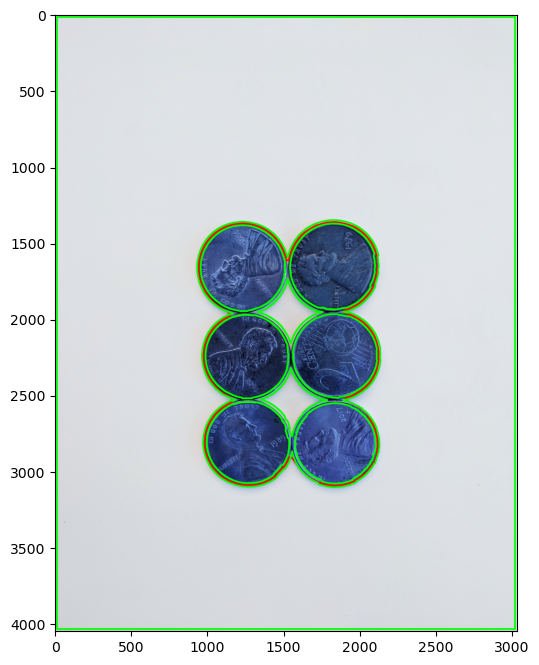

In [65]:
contours , hierarchy = cv2.findContours(markers.copy(),cv2.RETR_CCOMP,cv2.CHAIN_APPROX_SIMPLE)
for i in range(len(contours)):
    if hierarchy[0][i][3] == -1:
        cv2.drawContours(sep_coins,contours,i,(0,255,0),10)

display(sep_coins)